In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Tidak perlu dirubah
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Data

### Data experiment

##Data Preprocessing

In [4]:
from torch.utils.data import DataLoader, Dataset, TensorDataset

class TitanicDataset:
    def __init__(self, data, data_prep_version='1'):
        self.data_prep_version = data_prep_version
        self.data = self._data_preprocessing(data)

    def _data_preprocessing(self, data):
        if self.data_prep_version == '1':
            from sklearn.preprocessing import LabelEncoder
            le = LabelEncoder()

            out = data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
            out['Sex'] = le.fit_transform(out['Sex'])
            out['Embarked'] = le.fit_transform(out['Embarked'])
            return out

        elif self.data_prep_version == '2':
            dummy_fields=['Sex', 'Embarked']
            for each in dummy_fields:
                dummies= pd.get_dummies(data[each], prefix= each, drop_first=False)
                data = pd.concat([data, dummies], axis=1)

            fields_to_drop=['PassengerId', 'Cabin', 'Name', 'Sex', 'Ticket', 'Embarked']
            out = data.drop(fields_to_drop, axis=1)
            return out

        elif self.data_prep_version == '3':
            dummy_fields=['Sex', 'Embarked']
            for each in dummy_fields:
                dummies= pd.get_dummies(data[each], prefix= each, drop_first=False)
                data = pd.concat([data, dummies], axis=1)

            fields_to_drop=['PassengerId', 'Cabin', 'Name', 'Sex', 'Ticket', 'Embarked']
            out = data.drop(fields_to_drop, axis=1)
            out['FamilySize'] = out['SibSp'] + out['Parch'] + 1
            return out

        else:
            pass

    def as_df(self):
        return self.data

In [5]:
import pandas as pd

df_train = pd.read_csv('/content/Perceptron Challenge Dataset/train_data_cl_v2.csv')
df_test = pd.read_csv('/content/Perceptron Challenge Dataset/test_data_cl_v2.csv')
df_gt = pd.read_csv('/content/Perceptron Challenge Dataset/test_data_GroundTruth_cl.csv')
df_test = pd.concat([df_gt, df_test], axis=1)


df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
data_version = 1

df_train_final = TitanicDataset(df_train, str(data_version)).as_df()
df_test_final = TitanicDataset(df_test, str(data_version)).as_df()

df_train_final.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


## Model

[Activation Function](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)

In [7]:
import torch
from torch import nn

torch.manual_seed(42)

class Perceptron(nn.Module):
    def __init__(self,
                 in_features: int,
                 out_features: int,
                 bias: bool =True):
        super().__init__()
        self.node = nn.Linear(
            in_features=in_features,
            out_features=out_features,
            bias=bias
        )
        # self.act_func = nn.Sigmoid()
        self.act_func = nn.ReLU()
        # self.act_func = nn.LeakyReLU()
        # self.act_func = nn.Tanh()


    def forward(self, x):
        out = self.node(x)
        return self.act_func(out)

## Training and testing

In [8]:
import os
from tqdm.auto import tqdm

torch.manual_seed(42)

def accuracy(logits, target, t):
    logits[logits < t] = 0
    logits[logits >= t] = 1
    return sum(logits == target) / len(target)

def train(model,
          train_dataloader,
          test_dataloader,
          loss_fn,
          optimizer,
          lr_scheduler=None,
          epochs=20,
          show_progress=True,
          device='cpu'):

    config = {
        'activation': model.act_func.__class__.__name__,
        'loss_function': loss_fn.__class__.__name__,
        'optimizer': optimizer.__class__.__name__,
        'batch_size': batch_size,
        'epochs': epochs,
        'learning_rate': optimizer.param_groups[0]['lr'],
        'lr_scheduler_step': scheduler.step_size
    }

    result = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = 0, 0

        model.to(device)
        # train mode
        model.train()
        for data in train_dataloader:
            # move data to available device (cpu/cuda)
            X, y = data[:, 1:].to(device), data[:, 0].to(device)

            # forward
            logits = model(X).squeeze(1)

            # backward
            loss = loss_fn(logits, y) # error
            optimizer.zero_grad() # reset gradient
            loss.backward() # count gradient
            optimizer.step() # perform update weights

            # accuracy
            acc = accuracy(logits, y, 0.5)

            # acumulate loss and accuracy
            train_loss += loss.item()
            train_acc += acc.item()

        test_loss, test_acc = 0, 0

        # eval mode
        model.eval()
        for data_test in test_dataloader:
            X_test, y_test = data_test[:, 1:].to(device), data_test[:, 0].to(device)

            with torch.inference_mode():
                test_logits = model(X_test).squeeze(1)
                test_loss += loss_fn(test_logits, y_test).item()
                test_acc += accuracy(test_logits, y_test, 0.5).item()

        train_loss, train_acc = train_loss / len(train_dataloader), train_acc / len(train_dataloader)
        test_loss, test_acc = test_loss / len(test_dataloader), test_acc / len(test_dataloader)

        if lr_scheduler is not None:
            lr_scheduler.step()

        result['train_loss'].append(train_loss)
        result['train_acc'].append(train_acc)
        result['test_acc'].append(test_acc)
        result['test_loss'].append(test_loss)

        if (epoch + 1) % 1 == 0 and show_progress:
            print(f"Epoch: {epoch+1:4d}/{epochs}",
                f"| Train Loss: {train_loss:.4f}",
                f"| Train Acc: {train_acc:.3%}",
                f"| Test Loss: {test_loss:.4f}",
                f"| Test Acc: {test_acc:.3%}"
            )

        torch.save(model.state_dict(), f'models/model_{epoch + 1}.pth')

    return result, config

In [9]:
batch_size = 16
epochs = 20
lr = 0.01
lr_scheduler_step = 4

In [10]:
torch.manual_seed(42)

df_train_final = TitanicDataset(df_train, str(data_version)).as_df()
df_test_final = TitanicDataset(df_test, str(data_version)).as_df()

train_ds = torch.Tensor(df_train_final.values)
test_ds = torch.Tensor(df_test_final.values)

train_dataloader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

test_dataloader = DataLoader(
    test_ds,
    batch_size=batch_size,
    num_workers=2
)

len(train_dataloader), len(test_dataloader)

(45, 21)

In [11]:
model = Perceptron(df_train_final.shape[-1]-1, 1, bias=True).to(device)
os.makedirs('models', exist_ok=True)
torch.manual_seed(42)

loss_fn = nn.MSELoss() # error
optimizer = torch.optim.Adam(params=model.parameters() , lr=lr) # update wights
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_scheduler_step, gamma=0.1) # scale down lr

result, config = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    epochs=epochs,
    loss_fn=loss_fn,
    optimizer=optimizer,
)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:    1/20 | Train Loss: 0.9430 | Train Acc: 59.861% | Test Loss: 0.3847 | Test Acc: 61.526%
Epoch:    2/20 | Train Loss: 0.4006 | Train Acc: 59.722% | Test Loss: 0.3847 | Test Acc: 61.526%
Epoch:    3/20 | Train Loss: 0.4004 | Train Acc: 59.722% | Test Loss: 0.3847 | Test Acc: 61.526%
Epoch:    4/20 | Train Loss: 0.3988 | Train Acc: 59.861% | Test Loss: 0.3847 | Test Acc: 61.526%
Epoch:    5/20 | Train Loss: 0.4028 | Train Acc: 59.583% | Test Loss: 0.3847 | Test Acc: 61.526%
Epoch:    6/20 | Train Loss: 0.4013 | Train Acc: 59.722% | Test Loss: 0.3847 | Test Acc: 61.526%
Epoch:    7/20 | Train Loss: 0.4040 | Train Acc: 59.722% | Test Loss: 0.3848 | Test Acc: 61.526%
Epoch:    8/20 | Train Loss: 0.4024 | Train Acc: 59.722% | Test Loss: 0.3848 | Test Acc: 61.526%
Epoch:    9/20 | Train Loss: 0.4020 | Train Acc: 59.722% | Test Loss: 0.3848 | Test Acc: 61.526%
Epoch:   10/20 | Train Loss: 0.4005 | Train Acc: 59.861% | Test Loss: 0.3846 | Test Acc: 61.526%
Epoch:   11/20 | Train Loss: 0

### Plot

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loss_and_acc(result, dir):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # Loss subplot
    ax1.plot(result['train_loss'], label='Train Loss')
    ax1.plot(result['test_loss'], label='Test Loss')
    ax1.set_title('Train')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Accuracy subplot
    ax2.plot(result['train_acc'], label='Train Accuracy')
    ax2.plot(result['test_acc'], label='Test Accuracy')
    ax2.set_title('Test')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    fig.tight_layout()
    fig.savefig(f'{dir}/result.jpg', format='jpg')
    plt.show()

def plot_feature_importances(model, df_train, dir):

    weights = model.node.weight.softmax(1).squeeze(0).cpu().detach().numpy()
    columns = df_train.columns[1:]

    # Sort features by importance
    items = dict(sorted(({c: w for c, w in zip(columns, weights)}).items(),
                       key=lambda x: x[-1],
                       reverse=True))

    # Create bar plot
    plt.barh(list(items.keys()), items.values(), color='blue')
    plt.xlabel("Weight Magnitude")
    plt.gca().invert_yaxis()
    plt.title("Feature Importances")
    plt.tight_layout()
    plt.savefig(f"{dir}/feature_important.jpg", format='jpg', bbox_inches='tight')

    plt.show()

### Push to hf

[link token](https://huggingface.co/settings/tokens)

In [13]:
from huggingface_hub import login
login()

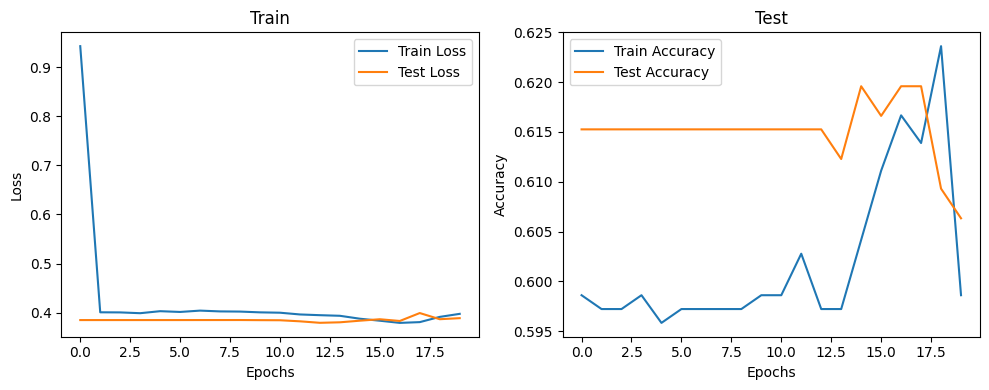

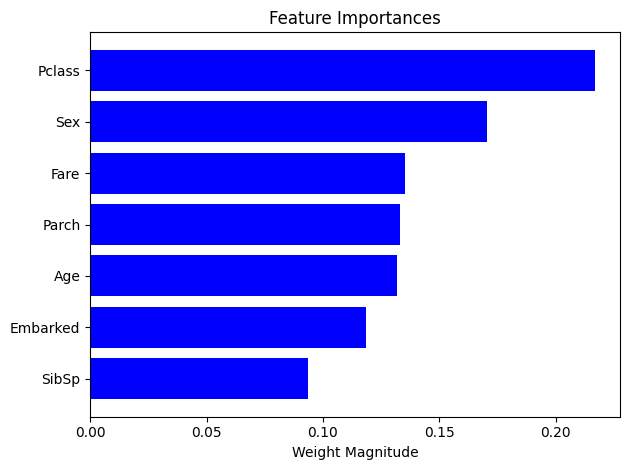

model_1.pth:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

model_10.pth:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

model_11.pth:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

Upload 22 LFS files:   0%|          | 0/22 [00:00<?, ?it/s]

feature_important.jpg:   0%|          | 0.00/29.1k [00:00<?, ?B/s]

model_12.pth:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

model_13.pth:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

model_16.pth:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

model_14.pth:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

model_15.pth:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

model_17.pth:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

model_18.pth:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

model_19.pth:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

model_2.pth:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

model_20.pth:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

model_3.pth:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

model_4.pth:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

model_5.pth:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

model_6.pth:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

model_7.pth:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

model_9.pth:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

model_8.pth:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

result.jpg:   0%|          | 0.00/36.6k [00:00<?, ?B/s]

dataV1/activation_ReLU/loss_function_MSELoss/optimizer_Adam/batch_size_16/epochs_20/learning_rate_0.01/lr_scheduler_step_4


In [14]:
# Jangan diubah

import os
import json
import shutil
from datetime import datetime, timedelta
from huggingface_hub import HfApi

dir = f'dataV{data_version}/' + '/'.join([f'{k}_{v}' for k, v in config.items()])

os.makedirs(dir, exist_ok=True)

result_object = json.dumps(result, indent=4)
config_object = json.dumps(config, indent=4)

with open(f"{dir}/result.json", "w") as outfile:
    outfile.write(result_object)

with open(f"{dir}/config.json", "w") as outfile:
    outfile.write(config_object)

plot_loss_and_acc(result, dir)
plot_feature_importances(model, df_train_final, dir)

if os.path.exists(f'{dir}/models'):
    shutil.rmtree(f'{dir}/models')

shutil.copytree('models', f'{dir}/models')

api = HfApi()
api.upload_folder(
    folder_path=f'dataV{data_version}',
    path_in_repo=f'dataV{data_version}',
    repo_id="JST4/Experiment",
    repo_type="dataset",
)

print(dir)

### Model TF


In [ ]:
X_train_tf = df_train_final.drop(['Survived'], axis=1)
y_train_tf = df_train_final['Survived']

In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential(
    tf.keras.layers.Dense(units=1, activation='sigmoid')
)

loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.03)

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

model.fit(X_train_tf, y_train_tf, batch_size=16, epochs=20)

Epoch 1/20
45/45 [==============================] - 3s 3ms/step - loss: 5.7835 - accuracy: 0.4494
Epoch 2/20
45/45 [==============================] - 0s 3ms/step - loss: 0.8133 - accuracy: 0.6671
Epoch 3/20
45/45 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.6938
Epoch 4/20
45/45 [==============================] - 0s 3ms/step - loss: 0.5780 - accuracy: 0.7205
Epoch 5/20
45/45 [==============================] - 0s 3ms/step - loss: 0.6126 - accuracy: 0.7472
Epoch 6/20
45/45 [==============================] - 0s 3ms/step - loss: 0.5253 - accuracy: 0.7598
Epoch 7/20
45/45 [==============================] - 0s 3ms/step - loss: 0.5565 - accuracy: 0.7458
Epoch 8/20
45/45 [==============================] - 0s 3ms/step - loss: 0.5242 - accuracy: 0.7753
Epoch 9/20
45/45 [==============================] - 0s 3ms/step - loss: 0.5224 - accuracy: 0.7725
Epoch 10/20
45/45 [==============================] - 0s 3ms/step - loss: 0.5025 - accuracy: 0.7767
Epoch 11/20
45/45 [

In [ ]:
model.weights

[<tf.Variable 'dense_5/kernel:0' shape=(10, 1) dtype=float32, numpy=
 array([[-0.37110183],
        [-0.01719019],
        [-0.29481763],
        [-0.09859852],
        [ 0.01068776],
        [ 1.9253975 ],
        [-0.53452075],
        [ 0.22411269],
        [-0.82537913],
        [-0.24307637]], dtype=float32)>,
 <tf.Variable 'dense_5/bias:0' shape=(1,) dtype=float32, numpy=array([0.54316676], dtype=float32)>]